# Construyendo un Motor de Autodiferenciación

<a href="https://colab.research.google.com/github/Antonio-Tresol/ai_workshop_2025_minigrad/blob/main/blank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Introducción

Un motor de autodiferenciación es un motor que permite definir funciones arbitrarias y calcular sus derivadas de manera automática.
Para ello, un motor de autodiferenciación necesita realizar dos cosas:

- construir un grafo que represente la función
- saber las dependencias de cada nodo en el grafo
- conocer el comportamiento local de cada operación definida en la función

Un ejemplo de un motor de autodiferenciación muy famoso es PyTorch Autograd. En este notebook, construiremos un motor de autodiferenciación simple desde cero.

Primero, veamos cómo se ve PyTorch Autograd en acción.

Este taller esta basado en <a href="https://github.com/karpathy/micrograd/tree/master">micrograd</a> de <a href="https://github.com/karpathy">Andrej Karpathy</a>.

------------------------------------------------------


Ejecute la celda a continuación para instalar las dependencias necesarias.

In [ ]:
!git clone https://github.com/Antonio-Tresol/ai_workshop_2025_minigrad.git
!apt -qqq install graphviz
%pip install matplotlib
%pip install numpy
%pip install graphviz
%pip install torch

In [ ]:
%cd ai_workshop_2025_minigrad

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

--------------------------------------------------------------------------------

Funciones auxiliares para visualizar el grafo.

In [ ]:
from graphviz import Digraph
from engine.engine import Value


def trace(root: Value) -> tuple[set[Value], set[tuple[Value, Value]]]:
    """Builds the expression graph, with all its vertices and directed edges."""
    nodes: set[Value] = set()
    edges: set[tuple[Value, Value]] = set()

    def dfs_build(v: Value) -> None:
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                dfs_build(child)

    dfs_build(root)
    return nodes, edges


def draw_dot(root: Value, format: str = "svg", rankdir: str = "LR") -> Digraph:
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ["LR", "TB"]
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={"rankdir": rankdir})
    # build all the nodes for the visualization
    for n in nodes:
        dot.node(
            name=str(id(n)),
            label=f"{{ {n.label} | data {n.data:.4f} | grad {n.grad:.4f}}}",
            shape="record",
        )
        if n._op:  # if the node was produce by an operation,
            # we add a node to the visualization to represented
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    # building the edges in the visualization
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## 1. PyTorch Autograd y Nuestro Mini-Grad

PyTorch Autograd es un motor de autodiferenciación que trabaja a nivel de tensores. En pocas palabras, un objeto matemático que contiene valores y dimensiones. Un tensor puede ser un escalar, un vector, una matriz o un tensor de orden superior. PyTorch Autograd construye un grafo dinámico que representa la función y calcula las derivadas de manera automática.

In [ ]:
# Crear tensores con seguimiento de gradiente
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

# Operaciones simples
z = 3 * x + y
w = z + y * x
z.retain_grad()
w.retain_grad()
# Calcular una función escalar final
f = w**2 / 2.0
f.retain_grad()

# Imprimir resultado del paso hacia adelante
print(f"Resultado: {f.item():.4f}")

# Calcular gradientes
f.backward()

# Imprimir los gradientes
print(f"df/dx: {z.grad.item():.4f}")
print(f"df/dy: {y.grad.item():.4f}")

tensor([2.], requires_grad=True)
Resultado: 112.5000
df/dx: 15.0000
df/dy: 45.0000


Mini-Grad es un motor de autodiferenciación simple que construiremos en este notebook. Mini-Grad también construirá un grafo que representa la función y calculará las derivadas de manera automática. Sin embargo, Mini-Grad tiene su building block en el nivel de escalares.

Resultado: 112.5000
df/dx: 15.0000
df/dy: 45.0000


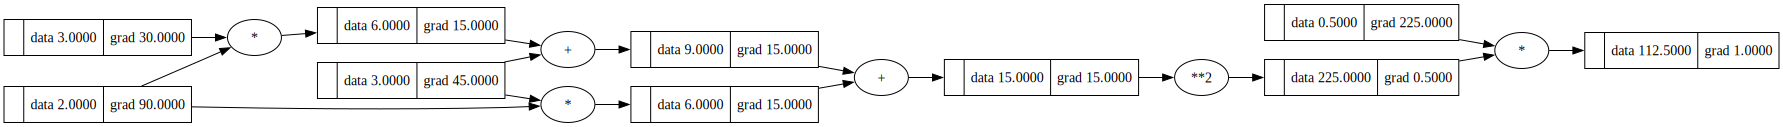

In [65]:
from engine.engine import Value

# Crear valores con seguimiento de gradiente
x = Value(2.0)
y = Value(3.0)

# Operaciones simples
z = 3 * x + y
w = z + y * x

# Calcular una función escalar final
f = w**2 / 2.0

# Imprimir resultado del paso hacia adelante
print(f"Resultado: {f.data:.4f}")

# Calcular gradientes
f.backward()

# Imprimir los gradientes
print(f"df/dx: {z.grad:.4f}")
print(f"df/dy: {y.grad:.4f}")
draw_dot(f)

## 2. Conceptos Básicos y todo a mano

En esta sección queremos asegurarnos que tenemos una muy buena comprensión de lo que hace una derivada.
Queremos entender que es lo que la derivada nos dice de la función, que es lo que esta midiendo.
Queremos tener clara la idea siguiente:  la derivada de una función nos dice como cambia su valor de salida cuando cambiamos su valor de entrada.

Esto tiene mucha relación con redes neuronales, pues estas son expresiones matemáticas enormes que dependen de muchos valores. Al inicio, esos valores son aleatorios y quisieramos saber como cambiar esos valores para que la salida de la red sea la deseada. La derivada nos dice como cambiar esos valores para que la salida de la red cambie de la manera que queremos.


$$
L = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}
$$


In [ ]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [ ]:
a = 2.0
b = -3
c = 10

d = a * b + c

## 3. Un Value básico para representar una expresión matemática arbitraria

En este espacio queremos contruir la fibras de nuestro motor. Algo sobre lo que se puedan hacer operaciones y mantenga el gráfo de la función.

In [ ]:
# class Value:
# operations plus mult
# graph building children
# labels
# visualization code

In [ ]:
# a = 2.0
# b = -3
# c = 10
# d = a * b + c
# f = -2
# L = d * f
# derivatives and its importance to backprop and nns

## 4. Automatizando la diferenciación
En este espacio queremos tomar el Value que tenemos y agregarle la capacidad para que almacene la derivada de la función con respecto a él.

In [ ]:
# grad manually L (def lol),
# chain rule
# explaining local behaviours of derivatives
# - sum distributes, mult crosses

# backprop -> recursive application of chain rule flowing from the head
# do one pass forward and one pass backwards

# back prop on neuron with Tanh -> go implement mult and div, and tanh
# not only atomic pieces

# grad automatic? how do we encode the value gradients and the output gradients
# self grad and other grad
# backwards propagates grads to its building values

# backwards needs to be done in order, topological sort, outside then abstract
# class Value:

## 5. Implementación de Mini-Grad Final

## 6. Una Red Neuronal Simple con Mini-Grad